In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

##########
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind, mannwhitneyu
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [5]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
movies_df=pd.read_csv("../input/movies-on-netflix-prime-video-hulu-and-disney/MoviesOnStreamingPlatforms.csv")
# Drop unwanted columns
movies_df = movies_df.drop(['Unnamed: 0', 'ID', 'Type'], axis='columns', errors='ignore')

# Display the first few rows
print(movies_df.head())

/kaggle/input/movies-on-netflix-prime-video-hulu-and-disney/MoviesOnStreamingPlatforms.csv
                                      Title  Year  Age Rotten Tomatoes  \
0                              The Irishman  2019  18+          98/100   
1                                    Dangal  2016   7+          97/100   
2  David Attenborough: A Life on Our Planet  2020   7+          95/100   
3         Lagaan: Once Upon a Time in India  2001   7+          94/100   
4                                      Roma  2018  18+          94/100   

   Netflix  Hulu  Prime Video  Disney+  
0        1     0            0        0  
1        1     0            0        0  
2        1     0            0        0  
3        1     0            0        0  
4        1     0            0        0  


In [6]:
#Features of dataset.
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9515 entries, 0 to 9514
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Title            9515 non-null   object
 1   Year             9515 non-null   int64 
 2   Age              5338 non-null   object
 3   Rotten Tomatoes  9508 non-null   object
 4   Netflix          9515 non-null   int64 
 5   Hulu             9515 non-null   int64 
 6   Prime Video      9515 non-null   int64 
 7   Disney+          9515 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 594.8+ KB


In [7]:
# Drop rows with NaN values in 'Rotten Tomatoes'
movies_df = movies_df.dropna(subset=['Rotten Tomatoes'])

# Ensure 'Rotten Tomatoes' is treated as a string and remove '/100'
movies_df['Rotten Tomatoes'] = movies_df['Rotten Tomatoes'].astype(str).str.replace('/100', '', regex=False)

# Convert 'Rotten Tomatoes' column to numeric type
movies_df['Rotten Tomatoes'] = pd.to_numeric(movies_df['Rotten Tomatoes'], errors='coerce')

# Display the updated DataFrame
print(movies_df.head())

                                      Title  Year  Age  Rotten Tomatoes  \
0                              The Irishman  2019  18+               98   
1                                    Dangal  2016   7+               97   
2  David Attenborough: A Life on Our Planet  2020   7+               95   
3         Lagaan: Once Upon a Time in India  2001   7+               94   
4                                      Roma  2018  18+               94   

   Netflix  Hulu  Prime Video  Disney+  
0        1     0            0        0  
1        1     0            0        0  
2        1     0            0        0  
3        1     0            0        0  
4        1     0            0        0  


In [8]:
print(movies_df['Age'].unique())

['18+' '7+' '13+' '16+' 'all' nan]


In [9]:
age_counts = movies_df['Age'].value_counts(dropna=False)
print(age_counts)

Age
NaN    4170
18+    2276
7+     1090
13+     998
all     698
16+     276
Name: count, dtype: int64


In [10]:
print(movies_df['Rotten Tomatoes'].unique())

[98 97 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 76 75 74
 73 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 51 50
 49 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30 29 28 27 24
 23 21 20 17 16 15 14 13 12 10 26 19 96]


Now the dataset contains the following columns

* Title: The Title of the Movie
* Year: The Year in which the Movie was released  Age: Age Required for watching the movie
* Rotten Tomatoes: The Rotten Tomatoes Score of the Movie (out of 100)
* Netflix: Whether the movie is present on Netflix or not (1 for True, 0 for False)
* Hulu: Whether the movie is present on Hulu or not (1 for True, 0 for False)
* Prime Video: Whether the movie is present on Prime Video or not (1 for True, 0 for False)
* Disney+: Whether the movie is present on Disney+ or not (1 for True, 0 for False)
r False)

In [11]:
#Features of dataset.
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9508 entries, 0 to 9514
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Title            9508 non-null   object
 1   Year             9508 non-null   int64 
 2   Age              5338 non-null   object
 3   Rotten Tomatoes  9508 non-null   int64 
 4   Netflix          9508 non-null   int64 
 5   Hulu             9508 non-null   int64 
 6   Prime Video      9508 non-null   int64 
 7   Disney+          9508 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 668.5+ KB


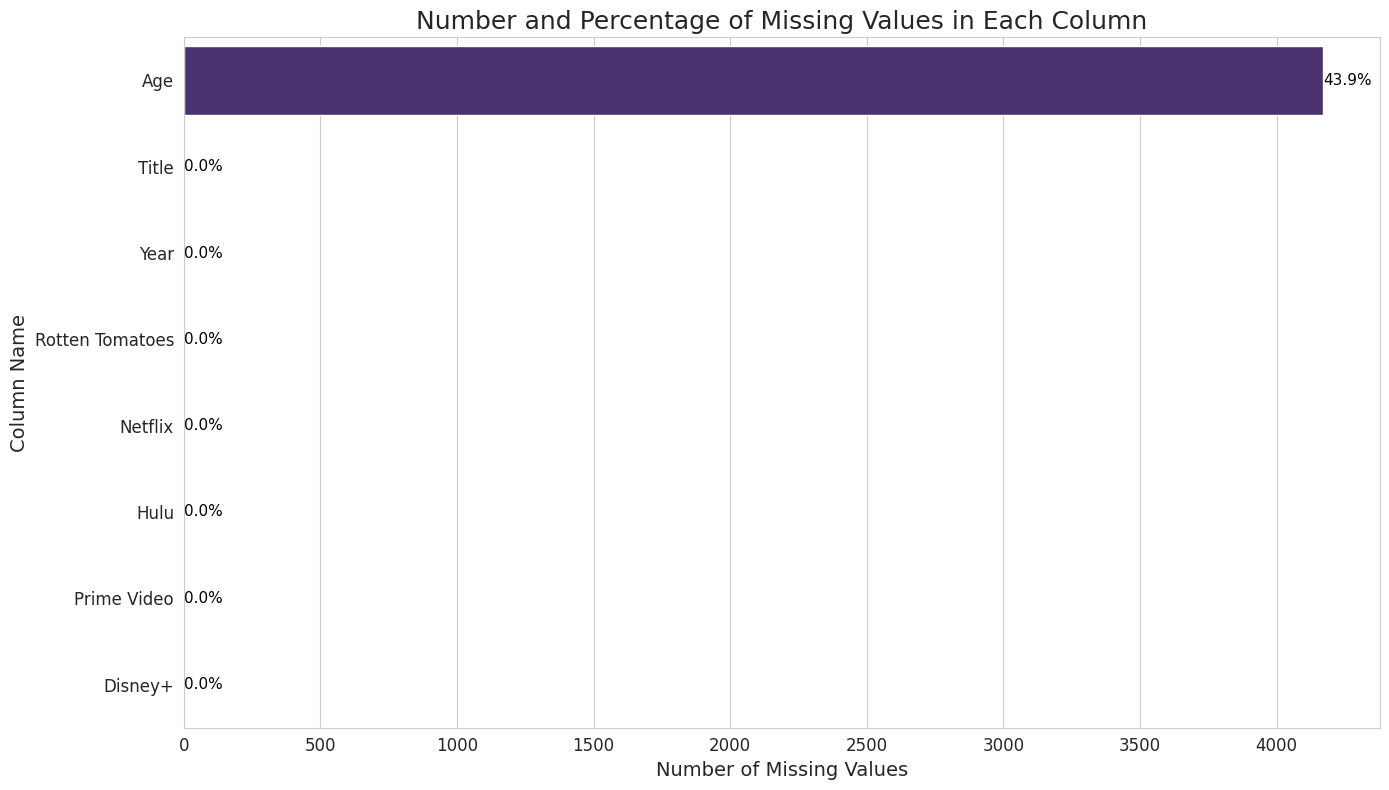

In [12]:
# Calculate the number of missing values and percentages for all columns
null_values = pd.DataFrame(movies_df.isnull().sum()).reset_index()
null_values = null_values.rename(columns={'index': 'Column Name', 0: 'Missing Values'})
null_values['Percentage Missing'] = (null_values['Missing Values'] / movies_df.shape[0]) * 100

# Sort the data by the number of missing values
null_values = null_values.sort_values(by='Missing Values', ascending=False)

# Set up the plot
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")
ax = sns.barplot(
    x='Missing Values',
    y='Column Name',
    data=null_values,
    palette="viridis"
)

# Annotate bars with the percentage of missing data
for i, (value, percent) in enumerate(zip(null_values['Missing Values'], null_values['Percentage Missing'])):
    ax.text(
        value + 1, i,  # Position to place the text
        f"{percent:.1f}%",  # Text to display
        color='black', 
        va='center', 
        fontsize=11
    )

# Add labels and title
plt.xlabel("Number of Missing Values", fontsize=14)
plt.ylabel("Column Name", fontsize=14)
plt.title("Number and Percentage of Missing Values in Each Column", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


In [13]:
print(movies_df['Age'].unique())

['18+' '7+' '13+' '16+' 'all' nan]


Age column has 43.9% missing data. hence the missing value will be named as 'unrt' for being unrated values.

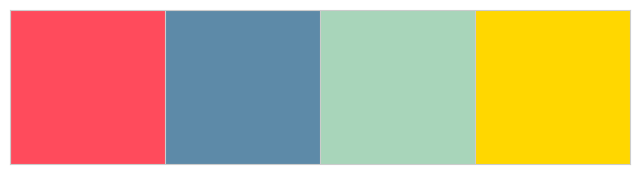

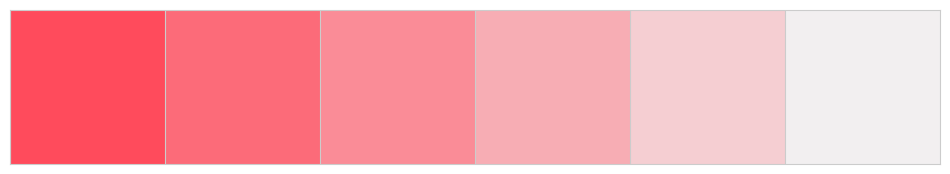

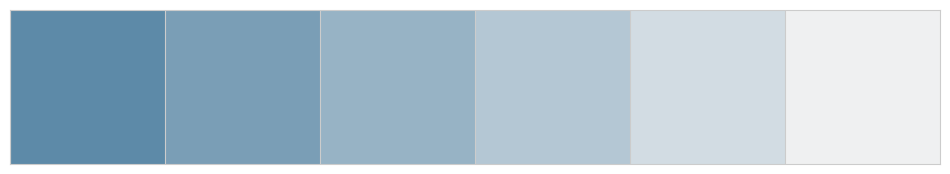

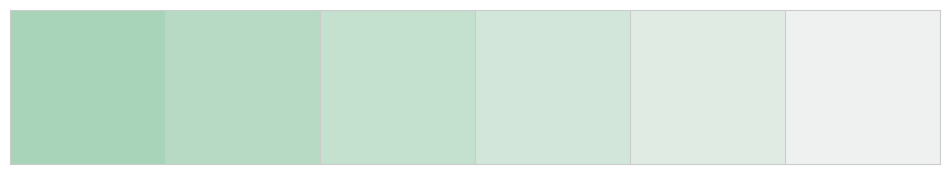

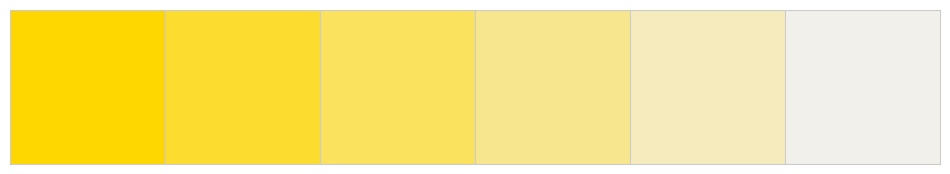

In [14]:
# Palette colors for streaming services
palette_colors = ["#FF4B5C", "#5D8AA8", "#A8D5BA", "#FFD700"]

# Set custom palette
custom_palette = sns.set_palette(sns.color_palette(palette_colors))
sns.palplot(sns.color_palette(palette_colors), size=2)

# Netflix: Reddish accents
netflix_palette = sns.light_palette("#FF4B5C", reverse=True)
sns.palplot(sns.color_palette(netflix_palette), size=2)

# Prime Video: Bluish hues
prime_palette = sns.light_palette("#5D8AA8", reverse=True)
sns.palplot(sns.color_palette(prime_palette), size=2)

# Hulu: Green-olive colors
hulu_palette = sns.light_palette("#A8D5BA", reverse=True)
sns.palplot(sns.color_palette(hulu_palette), size=2)

# Disney+: Fluorescent-yellowish
disney_palette = sns.light_palette("#FFD700", reverse=True)
sns.palplot(sns.color_palette(disney_palette), size=2)


In [15]:
movies_df['Age'].fillna('unrt', inplace=True)
movie_count = [movies_df[col].sum() for col in ["Netflix", "Prime Video", "Hulu", "Disney+"]]

# Create a list of DataFrames filtered by platform (Netflix, Hulu, Prime Video, Disney+)
platform_movies_list = [movies_df[(movies_df[col] == 1)] for col in ["Netflix", "Prime Video", "Hulu", "Disney+"]]

# Get the age distribution count for each platform, including the 'Unknown' category
movies_count_per_age = {col: df["Age"].value_counts().to_dict() for col, df in zip(["Netflix", "Prime Video", "Hulu", "Disney+"], platform_movies_list)}

# Display the result
print(movies_count_per_age)

{'Netflix': {'unrt': 1790, '18+': 877, '13+': 404, '7+': 322, '16+': 151, 'all': 144}, 'Prime Video': {'unrt': 1948, '18+': 1090, '7+': 421, '13+': 397, 'all': 160, '16+': 97}, 'Hulu': {'18+': 383, 'unrt': 329, '13+': 175, '7+': 98, 'all': 36, '16+': 26}, 'Disney+': {'all': 370, '7+': 278, 'unrt': 197, '13+': 70, '16+': 4, '18+': 3}}


# MEDIAN of the ratings for each OTT platform

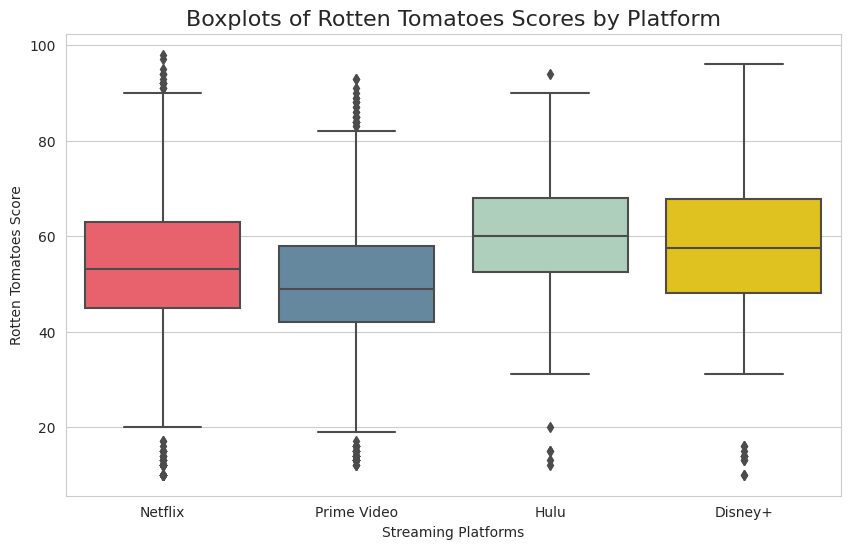

Overall Median Rotten Tomatoes Score: 52.0
Median Ratings for Each Platform:
Netflix: 53.0
Prime Video: 49.0
Hulu: 60.0
Disney+: 57.5

Top and Bottom Rated Movies for Each Platform:

Netflix - Top 5 Rated Movies:
                                   Title  Rotten Tomatoes
                            The Irishman               98
                                  Dangal               97
David Attenborough: A Life on Our Planet               95
       Lagaan: Once Upon a Time in India               94
                                    Roma               94

Netflix - Bottom 5 Rated Movies:
                                                           Title  Rotten Tomatoes
Mariusz Kałamaga, Karol Kopiec, Wiolka Walaszczyk Hilarious Trio               10
                                                 Falz Experience               10
                                         You're Everything To Me               10
                                   Monty Python Conquers America             

In [16]:
platform_columns = ["Netflix", "Prime Video", "Hulu", "Disney+"]
platform_movies_list = [movies_df[movies_df[col] == 1] for col in platform_columns]

# Plotting boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=[df["Rotten Tomatoes"] for df in platform_movies_list],
    palette=palette_colors
)
plt.title("Boxplots of Rotten Tomatoes Scores by Platform", fontsize=16)
plt.xticks(range(len(platform_columns)), platform_columns)
plt.ylabel("Rotten Tomatoes Score")
plt.xlabel("Streaming Platforms")
plt.show()

# Find overall median score of the dataset
overall_median = movies_df["Rotten Tomatoes"].median()
print(f"Overall Median Rotten Tomatoes Score: {overall_median}")

# Median scores for each platform
median_ratings = {
    col: df["Rotten Tomatoes"].median() for col, df in zip(platform_columns, platform_movies_list)
}
print("Median Ratings for Each Platform:")
for platform, median in median_ratings.items():
    print(f"{platform}: {median}")

# List top 5 and bottom 5 rated movies for each platform
top_bottom_movies = {}
for col, df in zip(platform_columns, platform_movies_list):
    sorted_movies = df.sort_values(by="Rotten Tomatoes", ascending=False)
    top_5 = sorted_movies[["Title", "Rotten Tomatoes"]].head(5)
    bottom_5 = sorted_movies[["Title", "Rotten Tomatoes"]].tail(5)
    top_bottom_movies[col] = {"Top 5": top_5, "Bottom 5": bottom_5}

print("\nTop and Bottom Rated Movies for Each Platform:")
for platform, movies in top_bottom_movies.items():
    print(f"\n{platform} - Top 5 Rated Movies:")
    print(movies["Top 5"].to_string(index=False))
    print(f"\n{platform} - Bottom 5 Rated Movies:")
    print(movies["Bottom 5"].to_string(index=False))

**Donut plot**

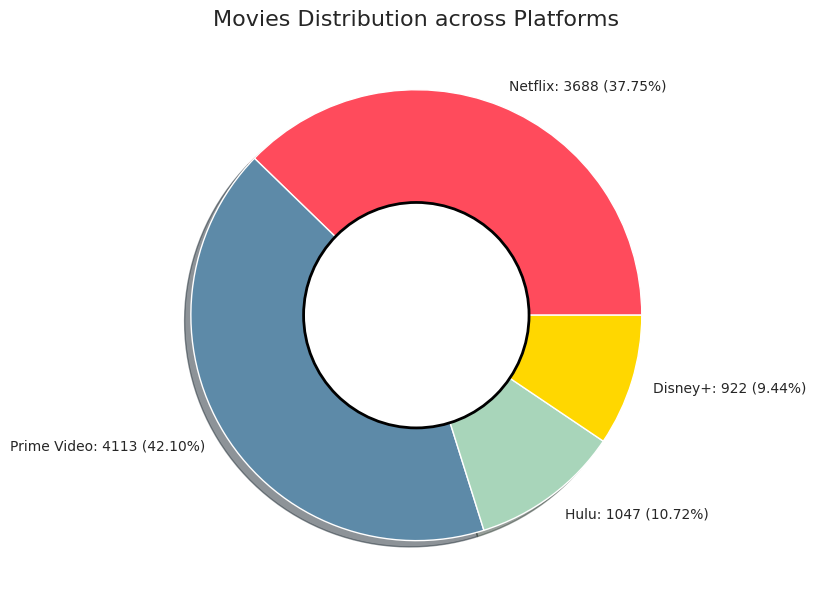

In [17]:
def donut_plot(splot, data, labels, title):
    plt.subplot(splot)
    
    # Create the donut center circle
    donut_center_circle = plt.Circle((0, 0), 0.5, color="black", fc="white", linewidth=2)
    
    # Calculate total movies
    total_movies = sum(data)
    
    # Format the labels to include both percentage and number of movies
    formatted_labels = [
        f"{label}: {value} ({value/total_movies:.2%})" for label, value in zip(labels, data)
    ]
    
    # Plot the pie chart
    plt.pie(
        data,
        labels=formatted_labels,
        colors=palette_colors,
        autopct=None,  # Disable the default percentage autopct
        shadow=True,
    )
    
    # Add the center circle for the donut
    current_fig = plt.gcf()
    current_fig.gca().add_artist(donut_center_circle)
    
    # Set the title
    plt.title(title, fontsize=16)

# Create the plot
plt.figure(figsize=(16, 8))
donut_plot(
    121, 
    movie_count, 
    ["Netflix", "Prime Video", "Hulu", "Disney+"], 
    "Movies Distribution across Platforms"
)
plt.show()


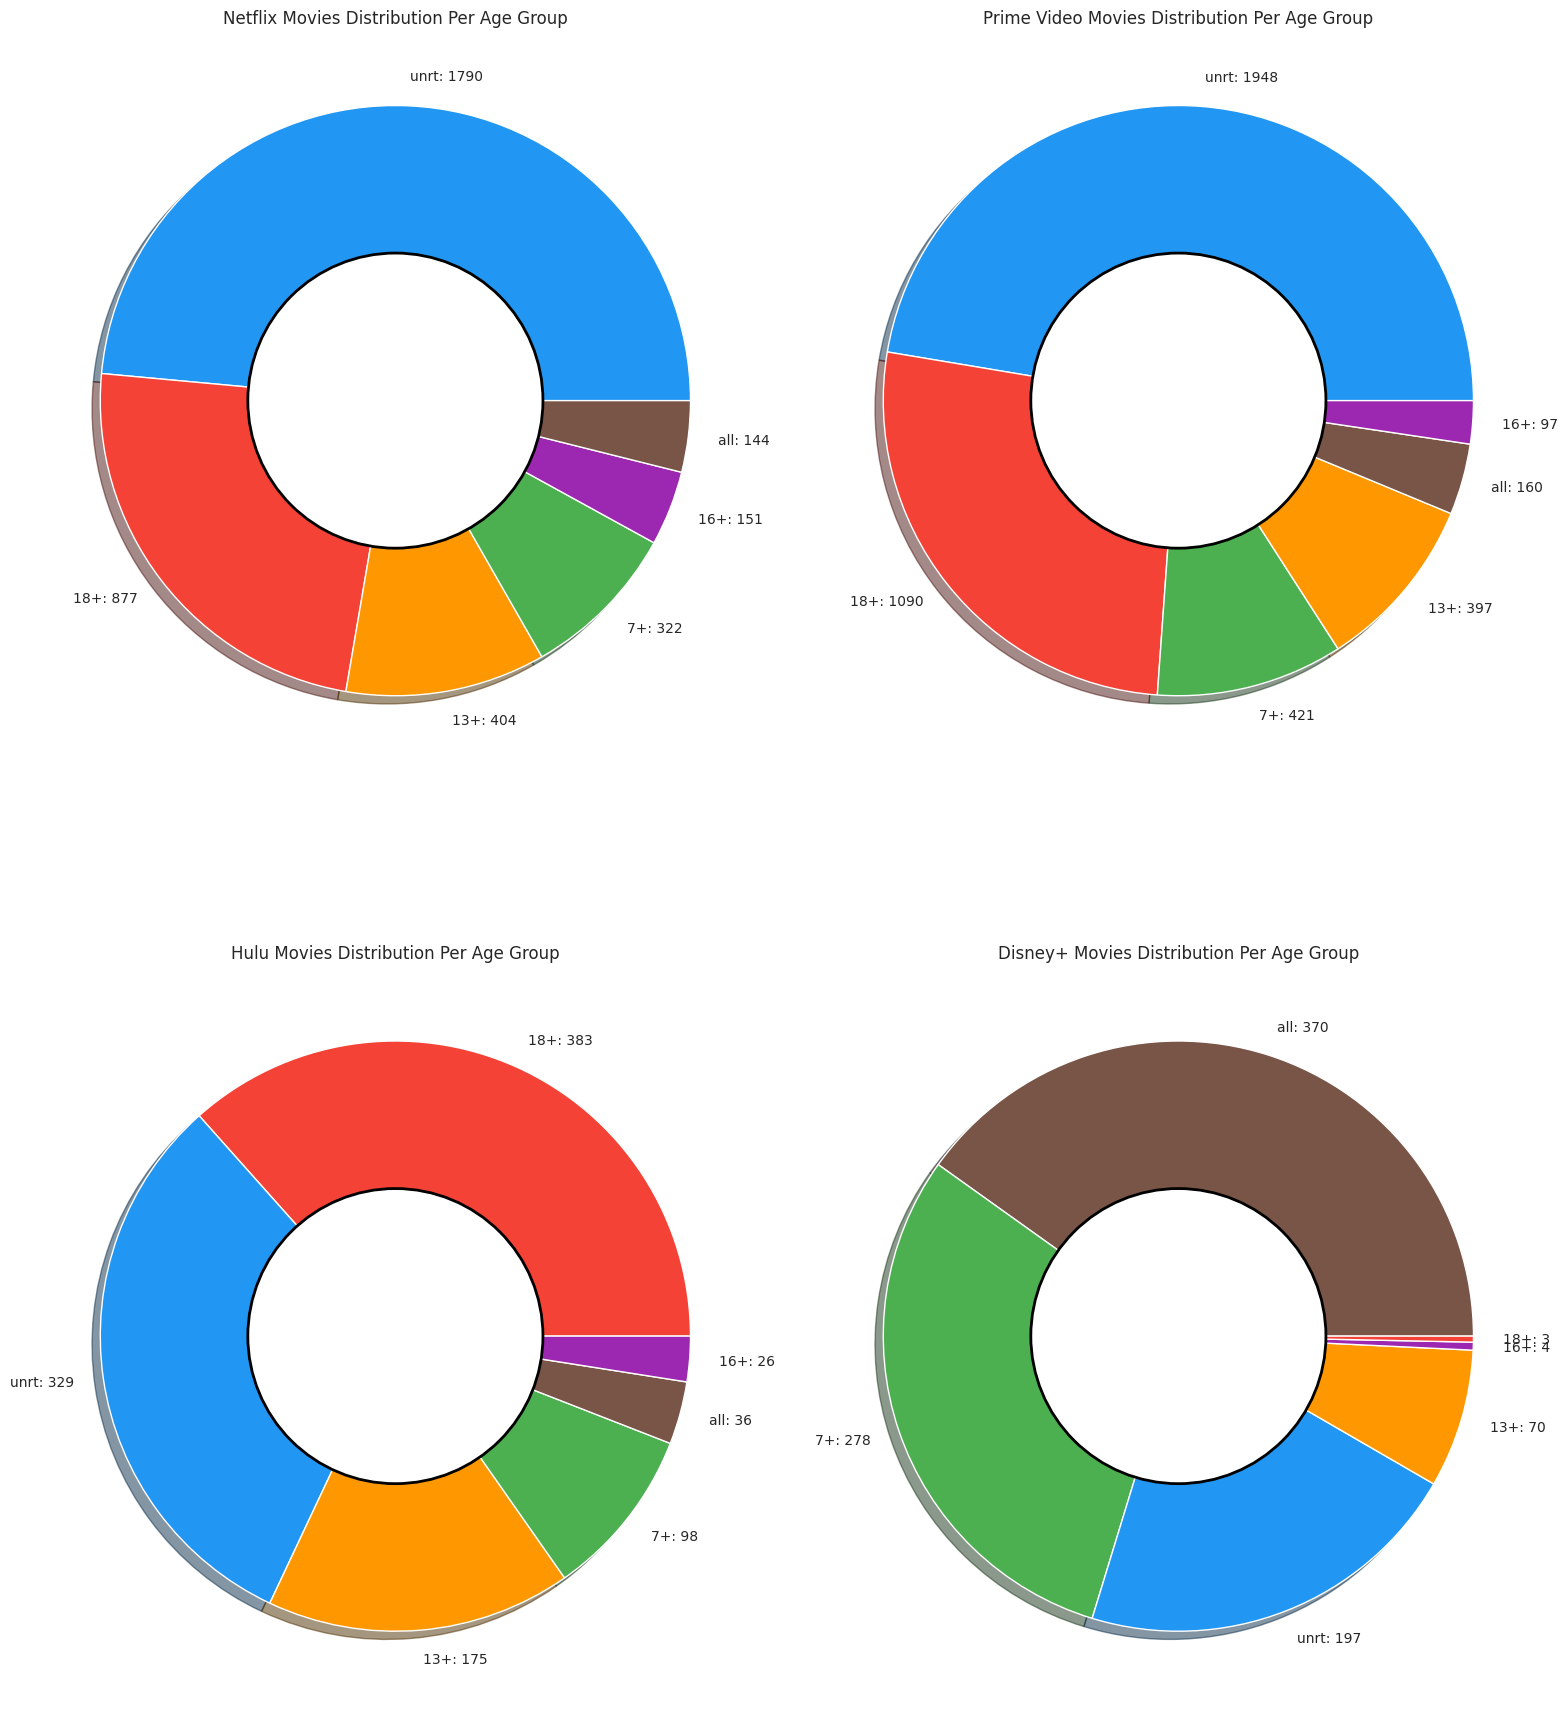

In [18]:
age_categories = ["7+", "13+", "16+", "18+", "all", "unrt"]
age_colors = {
    "7+": "#4CAF50",       # Green
    "13+": "#FF9800",      # Orange
    "16+": "#9C27B0",      # Purple
    "18+": "#F44336",      # Red
    "all": "#795548",      # Brown
    "unrt": "#2196F3",     # Blue
}

# Generate color lists for each platform
def get_colors_for_categories(categories):
    return [age_colors[cat] for cat in categories]

# Updated donut_plot function to include movie counts in labels
def donut_plot(splot, data, labels, title):
    plt.subplot(splot)
    
    # Format labels to include both age category and number of movies
    formatted_labels = [f"{label}: {value}" for label, value in zip(labels, data)]
    
    # Add center circle for donut
    donut_center_circle = plt.Circle((0, 0), 0.5, color="black", fc="white", linewidth=2)
    
    # Plot pie chart
    plt.pie(
        data,
        labels=formatted_labels,
        colors=get_colors_for_categories(labels),
        autopct=None,  # Disable default percentage labels
        shadow=True,
    )
    
    # Add the center circle
    current_fig = plt.gcf()
    current_fig.gca().add_artist(donut_center_circle)
    
    # Add title
    plt.title(title)

# Plot the data for each platform
plt.figure(figsize=(16, 20))

donut_plot(
    221,
    list(movies_count_per_age["Netflix"].values()),
    list(movies_count_per_age["Netflix"].keys()),
    "Netflix Movies Distribution Per Age Group",
)
donut_plot(
    222,
    list(movies_count_per_age["Prime Video"].values()),
    list(movies_count_per_age["Prime Video"].keys()),
    "Prime Video Movies Distribution Per Age Group",
)
donut_plot(
    223,
    list(movies_count_per_age["Hulu"].values()),
    list(movies_count_per_age["Hulu"].keys()),
    "Hulu Movies Distribution Per Age Group",
)
donut_plot(
    224,
    list(movies_count_per_age["Disney+"].values()),
    list(movies_count_per_age["Disney+"].keys()),
    "Disney+ Movies Distribution Per Age Group",
)

plt.tight_layout()
plt.show()


                Netflix  Prime Video  Hulu  Disney+
7+                  322          421    98      278
13+                 404          397   175       70
16+                 151           97    26        4
18+                 877         1090   383        3
all                 144          160    36      370
unrt               1790         1948   329      197
Child-Friendly      466          581   134      648
Adult               877         1090   383        3


<Figure size 1200x600 with 0 Axes>

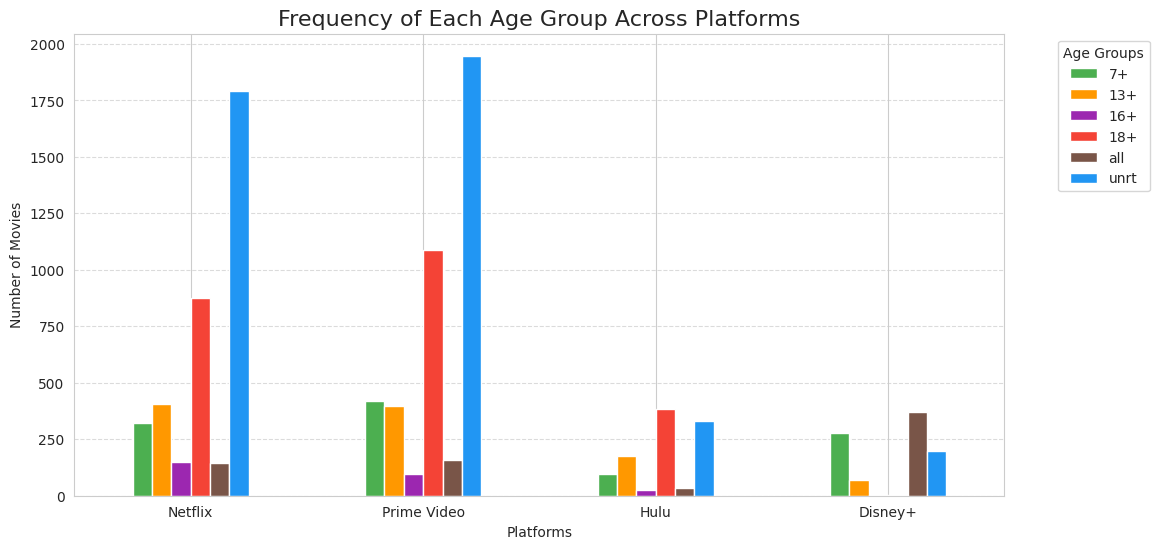

<Figure size 1000x600 with 0 Axes>

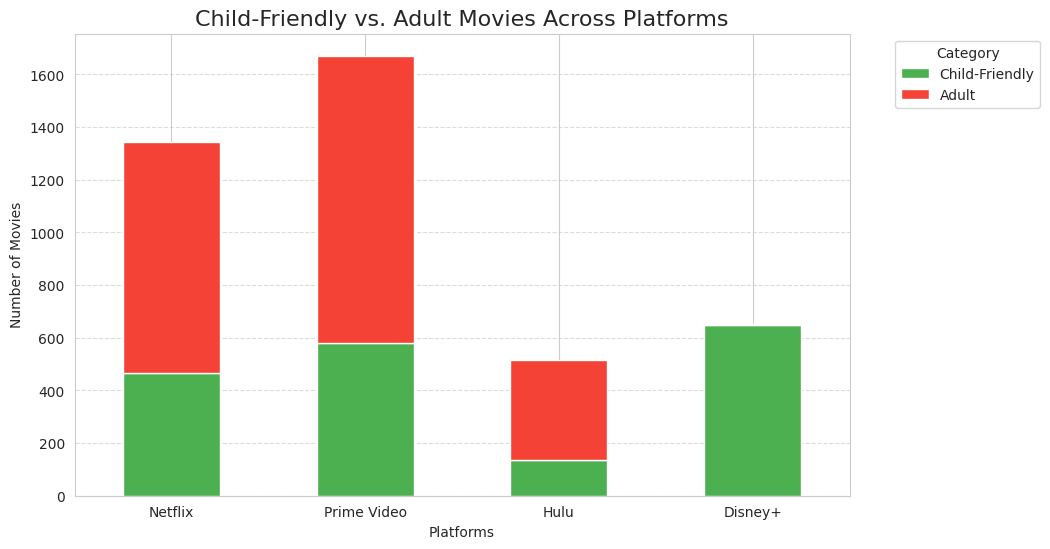

In [19]:
# Combine movies_count_per_age into a DataFrame
age_group_counts = pd.DataFrame(movies_count_per_age).fillna(0).astype(int)

# Ensure all expected age categories are present
expected_categories = ["7+", "13+", "16+", "18+", "all", "unrt"]
for category in expected_categories:
    if category not in age_group_counts.index:
        age_group_counts.loc[category] = 0  # Add missing categories with zero count

# Reorder rows to match the expected age group order
age_group_counts = age_group_counts.loc[expected_categories]

# Separate child-friendly ("all", "7+") and adult ("18+") categories
child_friendly = ["all", "7+"]
adult = ["18+"]

# Aggregate counts for child-friendly and adult categories for each platform
age_group_counts.loc["Child-Friendly"] = age_group_counts.loc[child_friendly].sum(axis=0)
age_group_counts.loc["Adult"] = age_group_counts.loc[adult].sum(axis=0)

# Print age_group_counts to debug
print(age_group_counts)

# Plot 1: Grouped Bar Chart for Frequency of Each Age Group
plt.figure(figsize=(12, 6))
age_group_counts.loc[expected_categories].T.plot(
    kind="bar", stacked=False, figsize=(12, 6), color=get_colors_for_categories(expected_categories)
)
plt.title("Frequency of Each Age Group Across Platforms", fontsize=16)
plt.ylabel("Number of Movies")
plt.xlabel("Platforms")
plt.legend(title="Age Groups", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Plot 2: Stacked Bar Chart for Child-Friendly vs. Adult Movies
plt.figure(figsize=(10, 6))
age_group_counts.loc[["Child-Friendly", "Adult"]].T.plot(
    kind="bar", stacked=True, figsize=(10, 6), color=["#4CAF50", "#F44336"]
)
plt.title("Child-Friendly vs. Adult Movies Across Platforms", fontsize=16)
plt.ylabel("Number of Movies")
plt.xlabel("Platforms")
plt.xticks(rotation=0)
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


above stacked graph shows that Disney+ is more child-friendly than Netflix

**Kernel Density Estimation Plot**
Number of movies in each platform by year

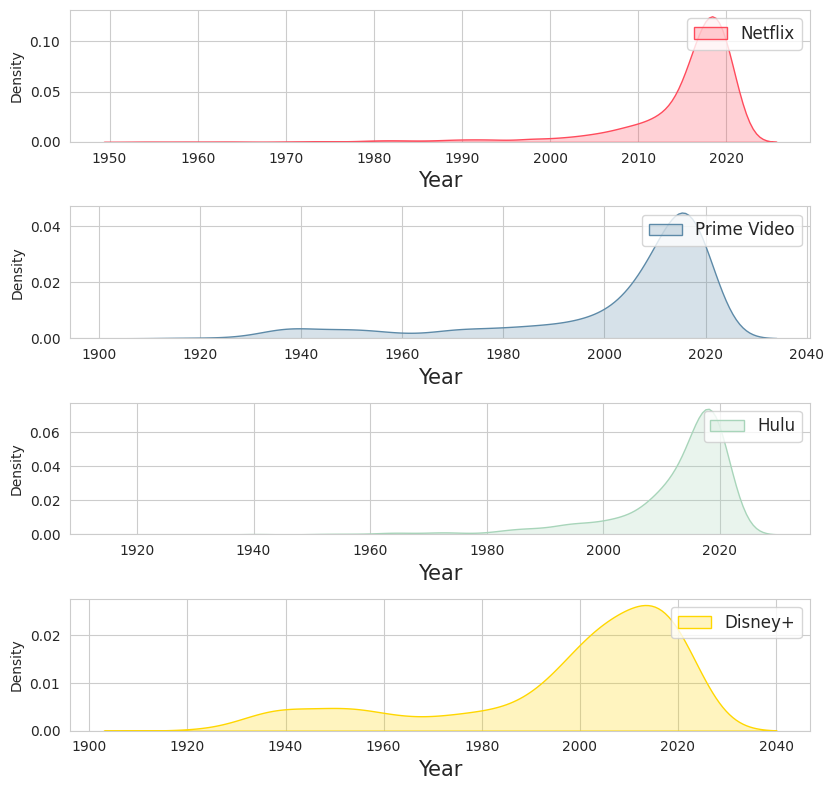

In [20]:
platform_names = ["Netflix", "Prime Video", "Hulu", "Disney+"]

def kde_plot(splot, i, col_name):
    plt.subplot(splot)
    sns.kdeplot(
        data=platform_movies_list[i][col_name],
        color=palette_colors[i],
        shade=True,
        label=platform_names[i]  # Use platform names
    )
    plt.xlabel(col_name, fontsize=15)
    plt.legend(fontsize=12)  # Display the legend with the platform name

plt.figure(figsize=(16, 8))
kde_plot(421, 0, 'Year')  # Netflix
kde_plot(423, 1, 'Year')  # Prime Video
kde_plot(425, 2, 'Year')  # Hulu
kde_plot(427, 3, 'Year')  # Disney+
plt.tight_layout()
plt.show()

                 Rotten Tomatoes      Year   Netflix  Prime Video      Hulu  \
Rotten Tomatoes         1.000000  0.035596  0.054464    -0.208164  0.182652   
Year                    0.035596  1.000000  0.306470    -0.243506  0.080546   
Netflix                 0.054464  0.306470  1.000000    -0.647565 -0.253133   
Prime Video            -0.208164 -0.243506 -0.647565     1.000000 -0.240009   
Hulu                    0.182652  0.080546 -0.253133    -0.240009  1.000000   
Disney+                 0.118378 -0.177820 -0.256481    -0.276798 -0.108462   

                  Disney+  
Rotten Tomatoes  0.118378  
Year            -0.177820  
Netflix         -0.256481  
Prime Video     -0.276798  
Hulu            -0.108462  
Disney+          1.000000  


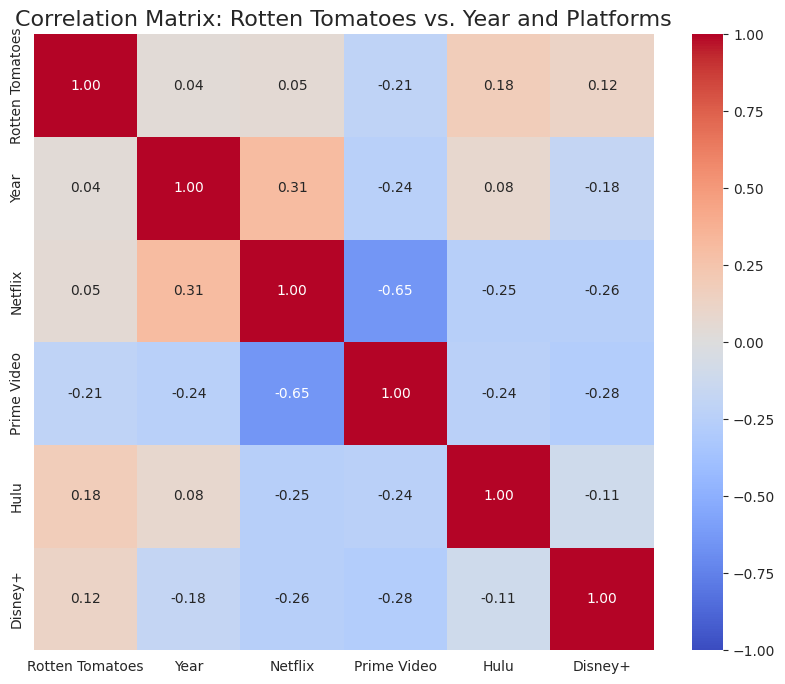

In [21]:
# Convert platform columns to binary (if not already)
platform_columns = ["Netflix", "Prime Video", "Hulu", "Disney+"]
for col in platform_columns:
    movies_df[col] = movies_df[col].apply(lambda x: 1 if x == 1 else 0)

# Ensure "Rotten Tomatoes" and "Release Year" are numeric
movies_df["Rotten Tomatoes"] = pd.to_numeric(movies_df["Rotten Tomatoes"], errors="coerce")
movies_df["Year"] = pd.to_numeric(movies_df["Year"], errors="coerce")

# Drop rows with missing values in the relevant columns
filtered_df = movies_df.dropna(subset=["Rotten Tomatoes", "Year"] + platform_columns)

# Compute correlations
correlation_data = filtered_df[["Rotten Tomatoes", "Year"] + platform_columns]
correlation_matrix = correlation_data.corr()

# Display the correlation matrix
print(correlation_matrix)

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix: Rotten Tomatoes vs. Year and Platforms", fontsize=16)
plt.show()


In [22]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9508 entries, 0 to 9514
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Title            9508 non-null   object
 1   Year             9508 non-null   int64 
 2   Age              9508 non-null   object
 3   Rotten Tomatoes  9508 non-null   int64 
 4   Netflix          9508 non-null   int64 
 5   Hulu             9508 non-null   int64 
 6   Prime Video      9508 non-null   int64 
 7   Disney+          9508 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 668.5+ KB


# Statistical Hypothesis Testing

**AGE RESTRICTION BETWEEN NETFLIX AND DISNEY+**

In [23]:
# Map age labels to numerical values
age_mapping = {
    "7+": 7,
    "13+": 13,
    "16+": 16,
    "18+": 18,
    "all": 1,  # No restriction
    "unrt": np.nan  # Treat unrated as missing values
}
movies_df["Age"] = movies_df["Age"].map(age_mapping)

# Drop rows with 'unrt' (already mapped to np.nan)
movies_df = movies_df.dropna(subset=["Age"])

# Filter data for Disney+ and Netflix
disney_data = movies_df[movies_df['Disney+'] == 1]
netflix_data = movies_df[movies_df['Netflix'] == 1]

# Drop rows with missing Age values
disney_age_restriction = disney_data["Age"].dropna()
netflix_age_restriction = netflix_data["Age"].dropna()

print("Mean Age Restriction on Disney+: ", disney_age_restriction.mean())
print("Mean Age Restriction on Netflix: ", netflix_age_restriction.mean())

# Perform an independent t-test
t_stat_age, p_value_age = ttest_ind(disney_age_restriction, netflix_age_restriction, equal_var=False)

# Interpret the results
if p_value_age < 0.05:
    print("The age restriction for movies on Disney+ is significantly different (lower/higher) than for Netflix.")
else:
    print("No significant difference in age restriction between Disney+ and Netflix.")

# Print t-statistic and p-value
print(f"Age Restriction: t-statistic = {t_stat_age:.2f}, p-value = {p_value_age:.4f}")


Mean Age Restriction on Disney+:  4.612413793103448
Mean Age Restriction on Netflix:  13.620653319283456
The age restriction for movies on Disney+ is significantly different (lower/higher) than for Netflix.
Age Restriction: t-statistic = -45.70, p-value = 0.0000


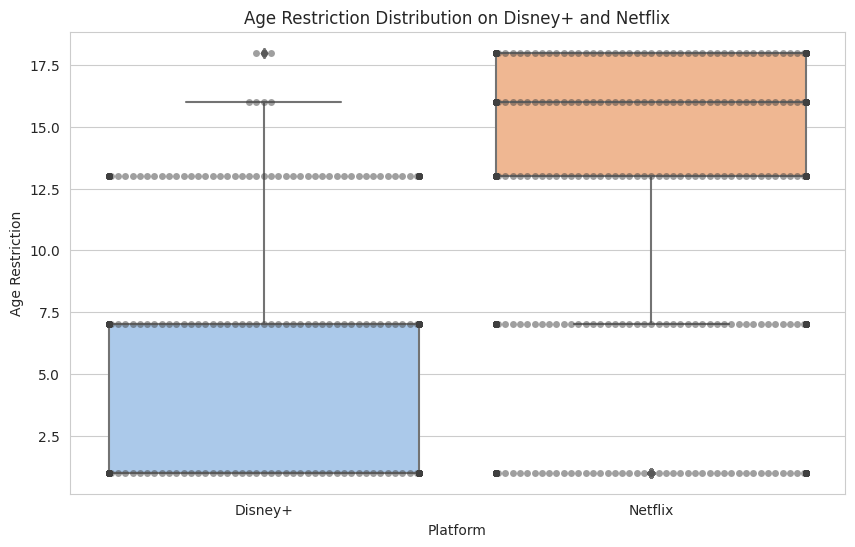

In [24]:
# Combine data into a single DataFrame for visualization
age_data = movies_df[movies_df["Disney+"] == 1].copy()
age_data["Platform"] = "Disney+"
netflix_age_data = movies_df[movies_df["Netflix"] == 1].copy()
netflix_age_data["Platform"] = "Netflix"
age_data = pd.concat([age_data, netflix_age_data])

# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x="Platform", y="Age", data=age_data, palette="pastel")
sns.swarmplot(x="Platform", y="Age", data=age_data, color=".25", alpha=0.5)
plt.title("Age Restriction Distribution on Disney+ and Netflix")
plt.ylabel("Age Restriction")
plt.xlabel("Platform")
plt.show()


**Difference in Rotten Tomatoes scores for movies on Disney+ and Netflix**

In [25]:
from scipy.stats import mannwhitneyu

# Ensure Rotten Tomatoes scores are numeric
movies_df["Rotten Tomatoes"] = pd.to_numeric(movies_df["Rotten Tomatoes"], errors='coerce')

# Filter data for Disney+ and Netflix
disney_scores = disney_data["Rotten Tomatoes"].dropna()
netflix_scores = netflix_data["Rotten Tomatoes"].dropna()

# Perform a Mann-Whitney U test (non-parametric test for score differences)
u_stat_score, p_value_score = mannwhitneyu(disney_scores, netflix_scores, alternative='two-sided')

# Calculate mean and median scores for additional insights
mean_disney = disney_scores.mean()
mean_netflix = netflix_scores.mean()
median_disney = disney_scores.median()
median_netflix = netflix_scores.median()

# Interpret the results
if p_value_score < 0.05:
    print("There is a significant difference in Rotten Tomatoes scores between Disney+ and Netflix.")
else:
    print("No significant difference in Rotten Tomatoes scores between Disney+ and Netflix.")

# Determine which platform has higher scores (based on mean or median)
if mean_disney > mean_netflix:
    print("Disney+ has higher average Rotten Tomatoes scores than Netflix.")
elif mean_disney < mean_netflix:
    print("Netflix has higher average Rotten Tomatoes scores than Disney+.")
else:
    print("Disney+ and Netflix have the same average Rotten Tomatoes scores.")

# Print U-statistic, p-value, and descriptive statistics
print(f"Rotten Tomatoes Scores: U-statistic = {u_stat_score:.2f}, p-value = {p_value_score:.4f}")
print(f"Disney+ Mean: {mean_disney:.2f}, Median: {median_disney:.2f}")
print(f"Netflix Mean: {mean_netflix:.2f}, Median: {median_netflix:.2f}")


There is a significant difference in Rotten Tomatoes scores between Disney+ and Netflix.
Disney+ has higher average Rotten Tomatoes scores than Netflix.
Rotten Tomatoes Scores: U-statistic = 730128.00, p-value = 0.0152
Disney+ Mean: 61.77, Median: 61.00
Netflix Mean: 60.50, Median: 60.00


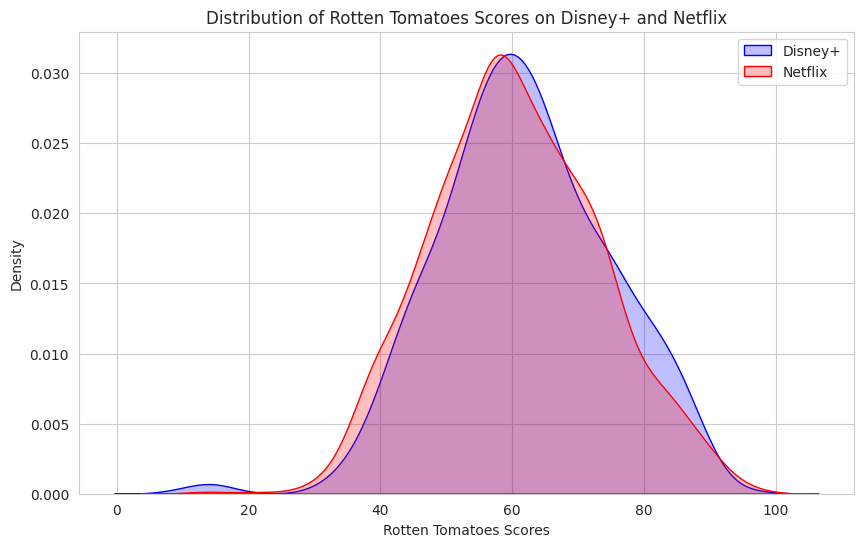

In [26]:
# Create KDE plots for Rotten Tomatoes scores
plt.figure(figsize=(10, 6))
sns.kdeplot(disney_scores, label="Disney+", shade=True, color="blue")
sns.kdeplot(netflix_scores, label="Netflix", shade=True, color="red")
plt.title("Distribution of Rotten Tomatoes Scores on Disney+ and Netflix")
plt.xlabel("Rotten Tomatoes Scores")
plt.ylabel("Density")
plt.legend()
plt.show()

In [27]:
movies_df.head(20)

,Title,Year,Age,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+
0,The Irishman,2019,18.0,98,1,0,0,0
1,Dangal,2016,7.0,97,1,0,0,0
2,David Attenborough: A Life on Our Planet,2020,7.0,95,1,0,0,0
3,Lagaan: Once Upon a Time in India,2001,7.0,94,1,0,0,0
4,Roma,2018,18.0,94,1,0,0,0
5,To All the Boys I've Loved Before,2018,13.0,94,1,0,0,0
6,The Social Dilemma,2020,13.0,93,1,0,0,0
7,Okja,2017,13.0,92,1,0,0,0
8,The Ballad of Buster Scruggs,2018,16.0,92,1,0,0,0
9,The Trial of the Chicago 7,2020,18.0,92,1,0,0,0


In [28]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5338 entries, 0 to 9514
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            5338 non-null   object 
 1   Year             5338 non-null   int64  
 2   Age              5338 non-null   float64
 3   Rotten Tomatoes  5338 non-null   int64  
 4   Netflix          5338 non-null   int64  
 5   Hulu             5338 non-null   int64  
 6   Prime Video      5338 non-null   int64  
 7   Disney+          5338 non-null   int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 375.3+ KB


In [29]:
import pandas as pd

# Assuming you have a DataFrame `df` already loaded with the given dataset
# Filter data for Netflix (where Netflix == 1) and Disney+ (where Disney+ == 1)
netflix_movies = movies_df[movies_df['Netflix'] == 1]
disney_movies = movies_df[movies_df['Disney+'] == 1]
prime_movies = movies_df[movies_df['Prime Video'] == 1]
hulu_movies = movies_df[movies_df['Hulu'] == 1]

# Mean, median, mode for Netflix
netflix_mean = netflix_movies['Rotten Tomatoes'].mean()
netflix_median = netflix_movies['Rotten Tomatoes'].median()
netflix_mode = netflix_movies['Rotten Tomatoes'].mode()[0]

hulu_mean = hulu_movies['Rotten Tomatoes'].mean()
hulu_median = hulu_movies['Rotten Tomatoes'].median()
hulu_mode = hulu_movies['Rotten Tomatoes'].mode()[0]

# Mean, median, mode for Disney+
disney_mean = disney_movies['Rotten Tomatoes'].mean()
disney_median = disney_movies['Rotten Tomatoes'].median()
disney_mode = disney_movies['Rotten Tomatoes'].mode()[0]

# Mean, median, mode for Prime Video
prime_mean = prime_movies['Rotten Tomatoes'].mean()
prime_median = prime_movies['Rotten Tomatoes'].median()
prime_mode = prime_movies['Rotten Tomatoes'].mode()[0]

# Print the results
print(f"Netflix Movies - Mean: {netflix_mean}, Median: {netflix_median}, Mode: {netflix_mode}")
print(f"Disney+ Movies - Mean: {disney_mean}, Median: {disney_median}, Mode: {disney_mode}")
print(f"Prime Video Movies - Mean: {prime_mean}, Median: {prime_median}, Mode: {prime_mode}")
print(f"Hulu Movies - Mean: {hulu_mean}, Median: {hulu_median}, Mode: {hulu_mode}")

Netflix Movies - Mean: 60.49947312961012, Median: 60.0, Mode: 57
Disney+ Movies - Mean: 61.76965517241379, Median: 61.0, Mode: 56
Prime Video Movies - Mean: 54.41200923787529, Median: 54.0, Mode: 44
Hulu Movies - Mean: 63.51671309192201, Median: 64.0, Mode: 64


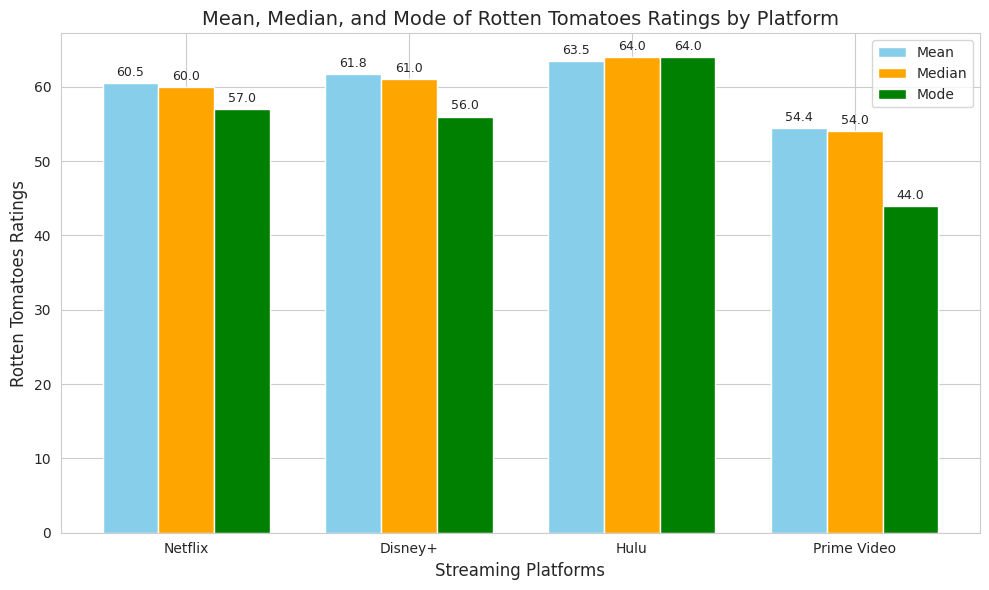

In [35]:
# Data for plotting
platforms = ['Netflix', 'Disney+', 'Hulu', 'Prime Video']
means = [netflix_mean, disney_mean, hulu_mean, prime_mean]
medians = [netflix_median, disney_median, hulu_median, prime_median]
modes = [netflix_mode, disney_mode, hulu_mode, prime_mode]

x = np.arange(len(platforms))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting bars
bar1 = ax.bar(x - width, means, width, label='Mean', color='skyblue')
bar2 = ax.bar(x, medians, width, label='Median', color='orange')
bar3 = ax.bar(x + width, modes, width, label='Mode', color='green')

# Add some text for labels, title, and axes
ax.set_xlabel('Streaming Platforms', fontsize=12)
ax.set_ylabel('Rotten Tomatoes Ratings', fontsize=12)
ax.set_title('Mean, Median, and Mode of Rotten Tomatoes Ratings by Platform', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(platforms, fontsize=10)
ax.legend(fontsize=10)

# Adding values on top of the bars
for bar_group in [bar1, bar2, bar3]:
    for bar in bar_group:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

# Display the chart
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from tabulate import tabulate

# Load your dataset into a DataFrame (assuming it's already loaded into `df`)

# Calculate the required statistics
stats = pd.DataFrame({
    "min": movies_df.select_dtypes(include=["float64", "int64"]).min(),
    "Q0.25": movies_df.select_dtypes(include=["float64", "int64"]).quantile(0.25),
    "median": movies_df.select_dtypes(include=["float64", "int64"]).median(),
    "mean": movies_df.select_dtypes(include=["float64", "int64"]).mean(),
    "std": movies_df.select_dtypes(include=["float64", "int64"]).std(),
    "Q0.75": movies_df.select_dtypes(include=["float64", "int64"]).quantile(0.75),
    "max": movies_df.select_dtypes(include=["float64", "int64"]).max()
})

# Use tabulate to pretty-print the table
print(tabulate(stats, headers="keys", tablefmt="grid"))
